In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torchvision
import torch.nn as nn
import torch.optim as optim
import sys
from captum.attr import GuidedGradCam
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

sys.path.insert(0, '../src')
from bird_dataset import *
from XAI_birds_dataloader import *
from models.multi_task_model import *
from XAI_birds_dataloader import *
from XAI_BirdAttribute_dataloader import *

In [2]:
# https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum

In [3]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [4]:
bd = BirdDataset(preload=True, attr_file='attributes')

In [5]:
'''With inspiration from https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855'''

import torch
import os
import PIL.Image as Image
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import sys
import torch.nn as nn


sys.path.insert(0, '../src')
from bird_dataset import *


class MultiTaskModel(nn.Module):
    """
    Creates a MTL model for the two attributes: 'has_bill_shape' and 'has_wing_color'
    """
    def __init__(self, model, dataset, ps=0.5):
        super(MultiTaskModel,self).__init__()
        
#         num_feats = model.classifier[6].in_features
#         features = list(model.classifier.children())[:-1]
#         features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
#         vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
        
        self.encoder = model        #fastai function that creates an encoder given an architecture
        # print(dataset.class_dict)
        self.dataset = dataset
        self.fc_dict = {}
        for key, value in self.dataset.class_dict.items():
            setattr(self, key, nn.Linear(1000, len(value)))

            # print(f'num_unique_vals in {key}: {len(value)}')
            self.fc_dict[key] = getattr(self, key)
            # self.eval(f'{key}') = nn.Linear(1000, len(value))
        # self.fc1 = nn.Linear(1000, 9)    
        # self.fc2 = nn.Linear(1000, 15)

    def forward(self,x, target=None):

#         x = nn.ReLU(self.encoder(x))
        x = self.encoder(x)
        print(f'Target: {target}')
        # bill_shape = self.fc1(x)
        # wing_color = self.fc2(x)
        if target is None: ret_vals = tuple([self.fc_dict[key](x) for key in self.dataset.class_dict])
        else:
            ret_val = [self.fc_dict[key](x) for key in self.dataset.class_dict]
#             print(ret_val)
            ret_vals = dict(zip(list(self.dataset.class_dict.keys()), [self.fc_dict[key](x) for key in self.dataset.class_dict]))
            ret_vals = ret_vals[target]
            print(ret_vals.size())
#         if len(ret_vals) == 1:
#             return ret_vals[0]
        return ret_vals

In [6]:
## TODO turn below cell into a function

In [7]:
# Bird_Attribute_Loader.__init__()

In [10]:
epochs=19
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = Bird_Attribute_Loader(bd, attrs=['has_bill_shape'], species=False, transform=trans, train=True, verbose=True)
val_bird_dataset = Bird_Attribute_Loader(bd, attrs=['has_bill_shape'], species=False, transform=trans, train=False, val=True, verbose=True)

label_dict = dict(zip(train_bird_dataset.class_dict.keys(), range(len(train_bird_dataset.class_dict.keys()))))
task_str = '__'.join(list(train_bird_dataset.class_dict.keys()))

vgg16 = models.vgg16_bn(pretrained=False)

model = MultiTaskModel(vgg16, train_bird_dataset)
model.load_state_dict(torch.load(f'../models/{task_str}_{epochs}_epoch_state_dict.pth'))

model.eval()
# batch_size = 4
trainloader = DataLoader(train_bird_dataset)
valloader = DataLoader(val_bird_dataset)

if torch.cuda.is_available():
    model.cuda()

In [19]:
np.where(np.array(val_bird_dataset.ids)==901)

(array([60]),)

In [10]:
np.where(np.array(val_bird_dataset.ids)==901)

(array([60]),)

In [11]:
def gradCAM_model(model, idx, model_name):
        last_conv = model.encoder.features[40]
        gc = GuidedGradCam(model, last_conv)
        samp = val_bird_dataset[idx]
        print(val_bird_dataset[idx])
        # samp = iter(valloader).next()
        img, label = samp['image'].cuda(), torch.LongTensor([samp['labels'][label_dict[model_name]]]).cuda()
        img = img.expand((1, 3, 224, 224))
#         print(type(img))
        print((label))
#         print(label.size())

        gc_img = gc.attribute(img, label, additional_forward_args=model_name)
#         gc_img+=0.0001
        # create custom colormap for visualizing the result
        default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                         [(0, '#ffffff'),
                                                          (0.25, '#000000'),
                                                          (1, '#000000')], N=256)


        # visualize the results using the visualize_image_attr helper method
        x = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     methods=["original_image", "heat_map"],
                                     signs=['all', 'positive'],
                                     cmap=default_cmap,
                                     show_colorbar=True)
        if os.path.exists(f'../figures/{task_str}')==False: os.mkdir(f'../figures/{model_name}')
        x[0].savefig(f'../figures/{task_str}/grad_cam_{model_name}_{idx}.png')

In [34]:
# bd.images[901]

In [29]:
val_bird_dataset[123]

image_id:  5563


{'image': tensor([[[0.3412, 0.3451, 0.3569,  ..., 0.1765, 0.1451, 0.1882],
          [0.3451, 0.3529, 0.3608,  ..., 0.2118, 0.1804, 0.2078],
          [0.3451, 0.3490, 0.3608,  ..., 0.1882, 0.1922, 0.2157],
          ...,
          [0.3725, 0.3765, 0.3804,  ..., 0.2471, 0.2510, 0.2510],
          [0.3804, 0.3843, 0.3843,  ..., 0.2549, 0.2510, 0.2510],
          [0.3843, 0.3882, 0.3882,  ..., 0.2667, 0.2667, 0.2706]],
 
         [[0.2784, 0.2902, 0.2941,  ..., 0.1608, 0.1333, 0.1804],
          [0.2784, 0.2902, 0.2941,  ..., 0.1961, 0.1647, 0.1882],
          [0.2824, 0.2941, 0.2980,  ..., 0.1725, 0.1686, 0.1922],
          ...,
          [0.5216, 0.5255, 0.5294,  ..., 0.3490, 0.3412, 0.3294],
          [0.5255, 0.5333, 0.5333,  ..., 0.3569, 0.3451, 0.3333],
          [0.5294, 0.5373, 0.5373,  ..., 0.3608, 0.3529, 0.3412]],
 
         [[0.2196, 0.2275, 0.2353,  ..., 0.1490, 0.1255, 0.1882],
          [0.2196, 0.2314, 0.2392,  ..., 0.1882, 0.1569, 0.1961],
          [0.2235, 0.2392, 0.24

image_id:  2146
image_id:  2146
{'image': tensor([[[0.7333, 0.7216, 0.7059,  ..., 0.6039, 0.5922, 0.5843],
         [0.7333, 0.7255, 0.7020,  ..., 0.6000, 0.5961, 0.5922],
         [0.7373, 0.7255, 0.7098,  ..., 0.6078, 0.5961, 0.5725],
         ...,
         [0.4784, 0.4941, 0.4980,  ..., 0.8667, 0.8667, 0.8706],
         [0.4627, 0.4745, 0.4824,  ..., 0.8667, 0.8667, 0.8706],
         [0.4510, 0.4627, 0.4784,  ..., 0.8627, 0.8627, 0.8706]],

        [[0.7137, 0.7059, 0.6941,  ..., 0.5804, 0.5725, 0.5647],
         [0.7137, 0.7059, 0.6902,  ..., 0.5804, 0.5765, 0.5765],
         [0.7098, 0.7020, 0.6941,  ..., 0.5882, 0.5765, 0.5608],
         ...,
         [0.4745, 0.4824, 0.4863,  ..., 0.8078, 0.8078, 0.8118],
         [0.4627, 0.4706, 0.4745,  ..., 0.8118, 0.8078, 0.8118],
         [0.4549, 0.4627, 0.4706,  ..., 0.8078, 0.8039, 0.8118]],

        [[0.3961, 0.3882, 0.3765,  ..., 0.2588, 0.2549, 0.2471],
         [0.3961, 0.3882, 0.3725,  ..., 0.2588, 0.2549, 0.2588],
         [0.3961

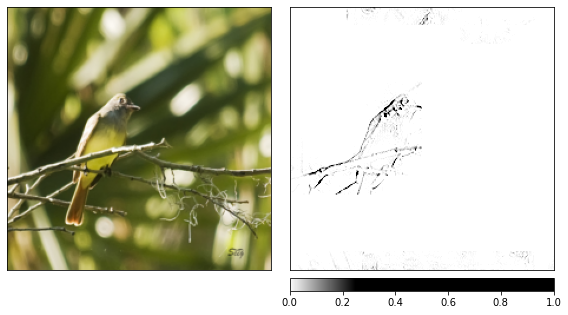

In [26]:
# # for i in range(10):
gradCAM_model(model, 62, 'has_wing_shape')

image_id:  11208
image_id:  11208
{'image': tensor([[[0.5020, 0.5216, 0.5098,  ..., 0.4118, 0.4039, 0.4039],
         [0.5216, 0.5216, 0.5098,  ..., 0.4078, 0.4039, 0.3961],
         [0.5255, 0.5176, 0.5098,  ..., 0.4078, 0.4039, 0.3961],
         ...,
         [0.7490, 0.7569, 0.7686,  ..., 0.6667, 0.6627, 0.6627],
         [0.7373, 0.7451, 0.7686,  ..., 0.6784, 0.6706, 0.6627],
         [0.7373, 0.7490, 0.7647,  ..., 0.6745, 0.6706, 0.6706]],

        [[0.4510, 0.4588, 0.4588,  ..., 0.3608, 0.3686, 0.3647],
         [0.4510, 0.4588, 0.4667,  ..., 0.3647, 0.3686, 0.3608],
         [0.4588, 0.4627, 0.4588,  ..., 0.3686, 0.3647, 0.3647],
         ...,
         [0.7490, 0.7608, 0.7686,  ..., 0.6588, 0.6627, 0.6549],
         [0.7373, 0.7412, 0.7569,  ..., 0.6706, 0.6706, 0.6627],
         [0.7255, 0.7412, 0.7569,  ..., 0.6863, 0.6784, 0.6745]],

        [[0.4157, 0.4235, 0.4275,  ..., 0.3569, 0.3529, 0.3451],
         [0.4235, 0.4275, 0.4157,  ..., 0.3569, 0.3569, 0.3490],
         [0.41

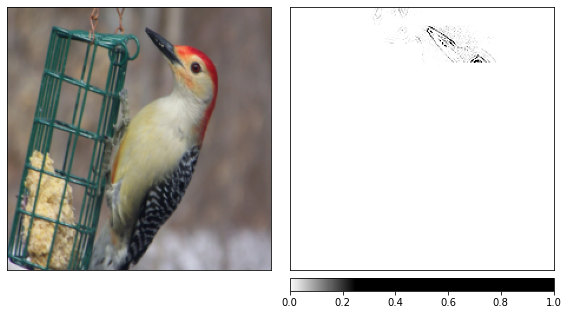

image_id:  11080
image_id:  11080
{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'labels': [1]}
tensor([1], device='cuda:0')
Target: has_bill_shape
torch.Size([1, 9])
Target: has_bill_shape
torch.Size([1, 9])


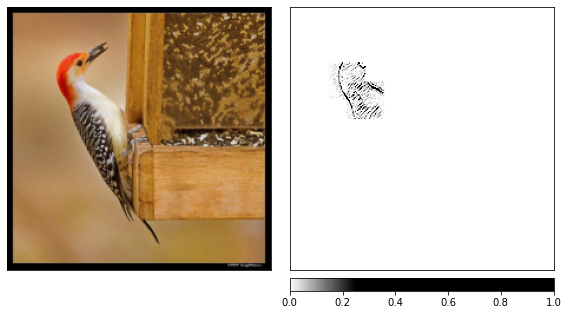

image_id:  11065
image_id:  11065
{'image': tensor([[[0.8118, 0.7843, 0.7647,  ..., 0.2902, 0.2745, 0.2824],
         [0.8275, 0.8000, 0.7608,  ..., 0.2784, 0.3255, 0.3294],
         [0.8510, 0.8314, 0.7961,  ..., 0.3765, 0.4000, 0.3804],
         ...,
         [0.4863, 0.4667, 0.4745,  ..., 0.1569, 0.1529, 0.1529],
         [0.4745, 0.4627, 0.4588,  ..., 0.1843, 0.1725, 0.1765],
         [0.3569, 0.3686, 0.3922,  ..., 0.2784, 0.2706, 0.2941]],

        [[0.6510, 0.6431, 0.6392,  ..., 0.3725, 0.3608, 0.3647],
         [0.6549, 0.6471, 0.6314,  ..., 0.3804, 0.4275, 0.4588],
         [0.6627, 0.6510, 0.6392,  ..., 0.4941, 0.5255, 0.5137],
         ...,
         [0.5020, 0.5020, 0.4980,  ..., 0.2196, 0.2118, 0.2157],
         [0.4980, 0.4980, 0.4902,  ..., 0.2667, 0.2627, 0.2627],
         [0.3843, 0.4235, 0.4353,  ..., 0.3882, 0.3804, 0.3922]],

        [[0.4902, 0.4706, 0.4549,  ..., 0.2039, 0.1961, 0.2118],
         [0.5216, 0.4902, 0.4667,  ..., 0.2157, 0.2314, 0.2196],
         [0.54

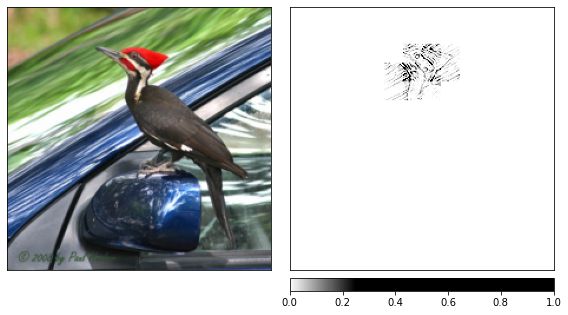

image_id:  552
image_id:  552
{'image': tensor([[[0.5529, 0.5647, 0.5843,  ..., 1.0000, 1.0000, 1.0000],
         [0.5333, 0.5490, 0.5686,  ..., 1.0000, 1.0000, 1.0000],
         [0.5255, 0.5373, 0.5569,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4980, 0.5020, 0.5020,  ..., 1.0000, 1.0000, 1.0000],
         [0.5333, 0.5961, 0.5529,  ..., 1.0000, 1.0000, 1.0000],
         [0.5451, 0.5725, 0.5176,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.6431, 0.6549, 0.6706,  ..., 1.0000, 1.0000, 1.0000],
         [0.6275, 0.6431, 0.6549,  ..., 1.0000, 1.0000, 1.0000],
         [0.6196, 0.6314, 0.6431,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.5490, 0.5647, 0.5922,  ..., 1.0000, 1.0000, 1.0000],
         [0.5725, 0.6510, 0.6353,  ..., 1.0000, 1.0000, 1.0000],
         [0.5765, 0.6235, 0.5882,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.7608, 0.7804, 0.8039,  ..., 1.0000, 1.0000, 1.0000],
         [0.7373, 0.7647, 0.7843,  ..., 1.0000, 1.0000, 1.0000],
         [0.7176, 

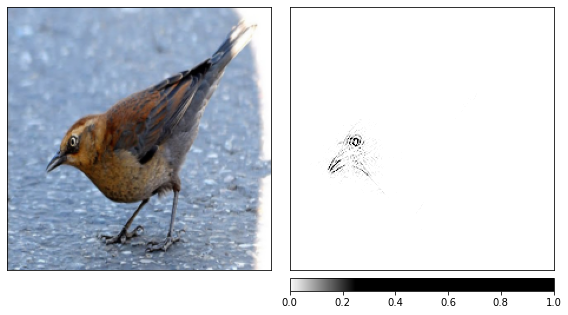

image_id:  11041
image_id:  11041
{'image': tensor([[[0.6980, 0.5451, 0.4941,  ..., 0.5961, 0.5647, 0.6784],
         [0.7608, 0.4745, 0.4706,  ..., 0.5882, 0.5804, 0.5569],
         [0.6745, 0.4235, 0.4471,  ..., 0.6039, 0.5922, 0.5843],
         ...,
         [0.2235, 0.3059, 0.3216,  ..., 0.4510, 0.4549, 0.5176],
         [0.2431, 0.1765, 0.1608,  ..., 0.4275, 0.4431, 0.3725],
         [0.2353, 0.2588, 0.2078,  ..., 0.4431, 0.4549, 0.4431]],

        [[0.8039, 0.7020, 0.6667,  ..., 0.7373, 0.7176, 0.8039],
         [0.8353, 0.5961, 0.6078,  ..., 0.7176, 0.7294, 0.7020],
         [0.7686, 0.5529, 0.5961,  ..., 0.7255, 0.7412, 0.7451],
         ...,
         [0.2667, 0.3882, 0.4039,  ..., 0.5020, 0.5255, 0.5725],
         [0.2824, 0.2431, 0.2000,  ..., 0.4784, 0.4941, 0.4118],
         [0.3294, 0.3451, 0.2588,  ..., 0.5137, 0.5137, 0.4980]],

        [[0.5765, 0.4667, 0.4078,  ..., 0.3843, 0.3255, 0.4824],
         [0.6902, 0.4157, 0.3529,  ..., 0.3647, 0.3490, 0.3843],
         [0.59

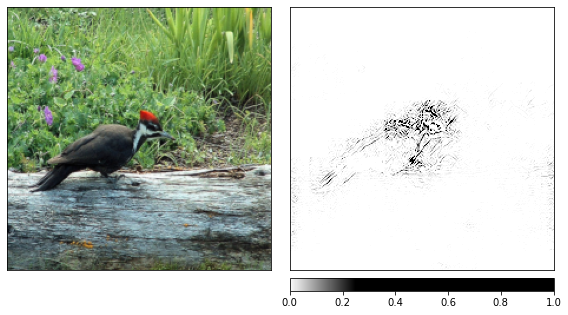

image_id:  11036
image_id:  11036
{'image': tensor([[[0.2118, 0.2549, 0.2706,  ..., 0.6431, 0.6353, 0.6549],
         [0.5373, 0.3647, 0.4471,  ..., 0.6235, 0.6314, 0.6275],
         [0.7294, 0.4980, 0.3294,  ..., 0.6078, 0.6196, 0.6157],
         ...,
         [0.2549, 0.2549, 0.2784,  ..., 1.0000, 1.0000, 1.0000],
         [0.2157, 0.2392, 0.2627,  ..., 1.0000, 1.0000, 1.0000],
         [0.2627, 0.2157, 0.2078,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.2549, 0.3059, 0.3176,  ..., 0.7176, 0.7098, 0.7255],
         [0.5647, 0.4078, 0.4824,  ..., 0.7020, 0.7098, 0.7098],
         [0.7451, 0.5294, 0.3725,  ..., 0.6902, 0.6980, 0.7020],
         ...,
         [0.2549, 0.2588, 0.2863,  ..., 1.0000, 1.0000, 1.0000],
         [0.2157, 0.2431, 0.2706,  ..., 1.0000, 1.0000, 1.0000],
         [0.2627, 0.2196, 0.2118,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.1373, 0.1922, 0.1961,  ..., 0.4353, 0.4235, 0.4627],
         [0.4902, 0.3216, 0.4000,  ..., 0.3922, 0.4078, 0.4118],
         [0.70

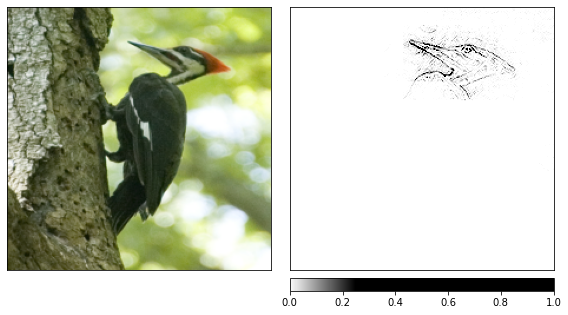

image_id:  5613
image_id:  5613
{'image': tensor([[[0.4471, 0.4549, 0.4510,  ..., 0.3961, 0.3765, 0.3647],
         [0.4824, 0.4784, 0.4902,  ..., 0.3804, 0.3647, 0.3647],
         [0.4588, 0.4118, 0.4078,  ..., 0.3725, 0.3725, 0.3843],
         ...,
         [0.3725, 0.3725, 0.3922,  ..., 0.4902, 0.4706, 0.4667],
         [0.3804, 0.3686, 0.3569,  ..., 0.5059, 0.4941, 0.4902],
         [0.3686, 0.3333, 0.2980,  ..., 0.5216, 0.5137, 0.5098]],

        [[0.5451, 0.5490, 0.5373,  ..., 0.4627, 0.4471, 0.4510],
         [0.5569, 0.5451, 0.5529,  ..., 0.4627, 0.4510, 0.4588],
         [0.5294, 0.4706, 0.4588,  ..., 0.4667, 0.4706, 0.4863],
         ...,
         [0.4275, 0.4314, 0.4549,  ..., 0.5373, 0.5216, 0.5137],
         [0.4510, 0.4353, 0.4196,  ..., 0.5608, 0.5529, 0.5451],
         [0.4353, 0.3882, 0.3529,  ..., 0.5804, 0.5725, 0.5647]],

        [[0.2471, 0.2588, 0.2627,  ..., 0.2471, 0.1373, 0.0706],
         [0.2863, 0.2824, 0.3020,  ..., 0.1333, 0.0549, 0.0235],
         [0.2706

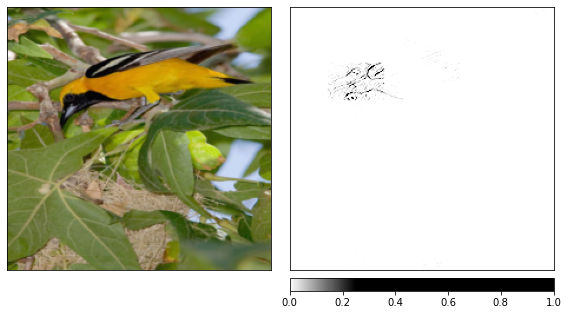

image_id:  653
image_id:  653
{'image': tensor([[[0.5098, 0.4392, 0.3725,  ..., 0.7608, 0.7608, 0.7608],
         [0.4588, 0.3961, 0.3412,  ..., 0.7647, 0.7647, 0.7647],
         [0.3922, 0.3451, 0.3137,  ..., 0.7686, 0.7686, 0.7686],
         ...,
         [0.6627, 0.6627, 0.6627,  ..., 0.3333, 0.3490, 0.3490],
         [0.6392, 0.6471, 0.6510,  ..., 0.3373, 0.3490, 0.3529],
         [0.6196, 0.6314, 0.6431,  ..., 0.3216, 0.3451, 0.3451]],

        [[0.5647, 0.4980, 0.4392,  ..., 0.7294, 0.7294, 0.7294],
         [0.5176, 0.4588, 0.4157,  ..., 0.7333, 0.7333, 0.7333],
         [0.4588, 0.4196, 0.3961,  ..., 0.7373, 0.7373, 0.7373],
         ...,
         [0.6745, 0.6745, 0.6745,  ..., 0.4353, 0.4353, 0.4353],
         [0.6510, 0.6588, 0.6627,  ..., 0.4627, 0.4549, 0.4588],
         [0.6314, 0.6431, 0.6549,  ..., 0.4627, 0.4588, 0.4588]],

        [[0.3216, 0.2588, 0.2039,  ..., 0.5882, 0.5882, 0.5882],
         [0.2706, 0.2157, 0.1725,  ..., 0.5922, 0.5922, 0.5922],
         [0.2000, 

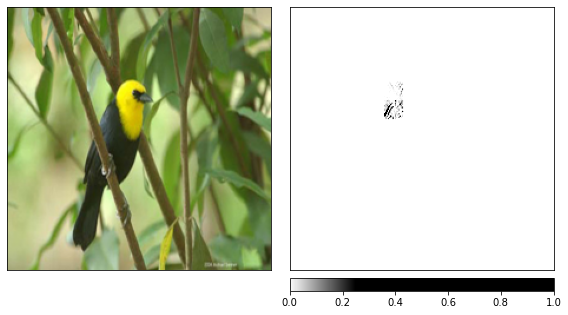

image_id:  2010
image_id:  2010
{'image': tensor([[[0.7373, 0.7373, 0.7333,  ..., 0.6510, 0.6235, 0.6039],
         [0.7255, 0.7294, 0.7333,  ..., 0.6863, 0.6549, 0.6392],
         [0.7294, 0.7294, 0.7294,  ..., 0.7098, 0.6824, 0.6706],
         ...,
         [0.7882, 0.7882, 0.7882,  ..., 0.4980, 0.4392, 0.3294],
         [0.7804, 0.7765, 0.7765,  ..., 0.3804, 0.3373, 0.2706],
         [0.7843, 0.7843, 0.7765,  ..., 0.1922, 0.1882, 0.1882]],

        [[0.7294, 0.7294, 0.7294,  ..., 0.6392, 0.6039, 0.5725],
         [0.7373, 0.7333, 0.7294,  ..., 0.6745, 0.6510, 0.6235],
         [0.7333, 0.7333, 0.7294,  ..., 0.6941, 0.6784, 0.6588],
         ...,
         [0.7922, 0.7882, 0.7961,  ..., 0.4980, 0.4392, 0.3294],
         [0.7765, 0.7725, 0.7765,  ..., 0.3804, 0.3373, 0.2706],
         [0.7765, 0.7765, 0.7765,  ..., 0.1922, 0.1882, 0.1882]],

        [[0.6784, 0.6784, 0.6824,  ..., 0.5725, 0.5451, 0.5176],
         [0.6824, 0.6863, 0.6824,  ..., 0.6078, 0.5765, 0.5569],
         [0.6824

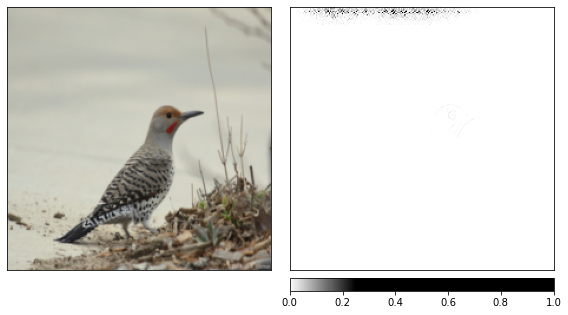

image_id:  907
image_id:  907
{'image': tensor([[[0.5294, 0.5255, 0.5255,  ..., 0.5647, 0.5725, 0.5765],
         [0.5294, 0.5294, 0.5294,  ..., 0.5647, 0.5765, 0.5765],
         [0.5294, 0.5333, 0.5294,  ..., 0.5725, 0.5765, 0.5765],
         ...,
         [0.4275, 0.4980, 0.5294,  ..., 0.5569, 0.5412, 0.5608],
         [0.4627, 0.5294, 0.5569,  ..., 0.5804, 0.5647, 0.5804],
         [0.4706, 0.5412, 0.5725,  ..., 0.5294, 0.5255, 0.5451]],

        [[0.5216, 0.5255, 0.5255,  ..., 0.5804, 0.5843, 0.5922],
         [0.5216, 0.5255, 0.5294,  ..., 0.5843, 0.5882, 0.5882],
         [0.5216, 0.5255, 0.5294,  ..., 0.5882, 0.5882, 0.5882],
         ...,
         [0.3412, 0.4157, 0.4471,  ..., 0.4824, 0.4745, 0.4941],
         [0.3765, 0.4471, 0.4667,  ..., 0.5020, 0.4941, 0.5098],
         [0.3686, 0.4471, 0.4784,  ..., 0.4549, 0.4510, 0.4667]],

        [[0.5255, 0.5216, 0.5176,  ..., 0.5608, 0.5608, 0.5686],
         [0.5255, 0.5176, 0.5216,  ..., 0.5569, 0.5608, 0.5647],
         [0.5255, 

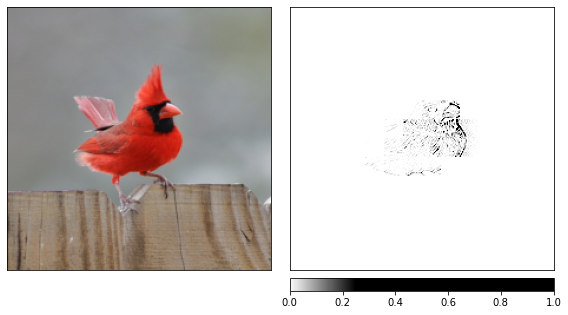

In [13]:
for i in range(10):
    gradCAM_model(model, np.random.choice(range(len(val_bird_dataset))), 'has_bill_shape')